In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Capstone

import re
import pandas as pd
import string

Mounted at /content/gdrive
/content/gdrive/MyDrive/Capstone


In [ ]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re
import nltk
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from keras import models
from keras import layers
from tensorflow.keras.layers import LSTM,GRU,InputLayer
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
CPU times: user 4.97 s, sys: 724 ms, total: 5.7 s
Wall time: 9.23 s


In [ ]:
! pip install spacy
! pip install spacy_cld
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.language import Language
from spacy_cld import LanguageDetector
nlp = spacy.load('en')
language_detector = LanguageDetector()
nlp.add_pipe(language_detector)

     |████████████████████████████████| 41.4 MB 2.2 MB/s 
  Created wheel for spacy-cld: filename=spacy_cld-0.1.0-py3-none-any.whl size=4065 sha256=1cbc0e1ed347d1fc4687c89f84bbbb899311faa1903db8c5f8c8a316955a5eec
  Stored in directory: /root/.cache/pip/wheels/82/6b/8f/260626615a2629391aca1fce5d3c676dde154f8aabb18d25bf
  Created wheel for pycld2: filename=pycld2-0.41-cp37-cp37m-linux_x86_64.whl size=9834294 sha256=4caf153d745fa7fa3560feb01cec2840a6f9daa6c69d7db59ee4a9bec3dbfcbf
  Stored in directory: /root/.cache/pip/wheels/ed/e4/58/ed2e9f43c07d617cc81fe7aff0fc6e42b16c9cf6afe960b614
Successfully built spacy-cld pycld2


In [ ]:
from sklearn import model_selection

In [ ]:
dt.loc[dt['tag']=="real",'tag'] = 1
dt.loc[dt['tag']=="fake",'tag']  = 0

In [ ]:
puncts = list(string.punctuation)
def clean_data(text):
  # delete punctuation
  for punc in puncts:
    if punc in text:
      text = text.replace(punc, f'')
  #make the text lower case
  text=text.lower()
  # delete the url
  text=re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text)
  # delete the email
  text=re.sub(r'^([\w]+\.*)([\w]+)\@[\w]+\.\w{3}(\.\w{2}|)', '', text)
  # delete @someone
  text=re.sub(r'@\S+', '', text)
  # delete #tags
  text=re.sub(r'#\S+', '', text)
  # delete \n
  text=re.sub(r'^\s*$(?:\n|\r\n)', '', text)
  return text

In [ ]:
dt['text']=dt['text'].apply(clean_data)

In [ ]:
dt['text'] = dt['text'].apply(lambda text: 
                                          " ".join(token.lemma_ for token in nlp(text) 
                                                   if not token.is_stop))

In [ ]:
train, test = model_selection.train_test_split(dt,test_size=0.2)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

def text_encoding(texts, labels, max_words, padding_length):
  tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token=None, document_count=0)
  tokenizer.fit_on_texts(texts)
  (word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
  
  def tokenizer_info(mylist):
    ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = True)
  tokenizer_info(word_counts)
  tokenizer_info(word_docs)
  tokenizer_info(word_index)    

  sequences = tokenizer.texts_to_sequences(texts)
  word_index = tokenizer.word_index

  corpus = keras.preprocessing.sequence.pad_sequences(sequences, value=0.0,
                                                      padding='post', maxlen= padding_length)
  return corpus, labels, tokenizer

max_words = 20000
padding_length = 100
corpus, labels, tokenizer = text_encoding(train.text, train.tag, max_words, padding_length)  

In [ ]:
training_data,training_labels=corpus, labels

In [ ]:
def define_callback():
  keras.backend.clear_session()
  accuracy_threshold = .999

  class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>accuracy_threshold):
          print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
          self.model.stop_training = True

  acc_callback = myCallback()
  return acc_callback

In [ ]:
class_names=[True,False]
def create_model(embedding_dim):
  keras.backend.clear_session()
  no_of_class = len(class_names)
  model = keras.models.Sequential([
      keras.layers.Embedding(max_words, embedding_dim, input_length = padding_length),
      keras.layers.Conv1D(64, 5, activation='relu'),
      keras.layers.MaxPooling1D(5),
      keras.layers.Bidirectional(LSTM(32, dropout=0.2)),
      keras.layers.Flatten(),
      keras.layers.Dense(no_of_class, activation = 'softmax')
  ])
  return model
def model_visualize(model):
  from tensorflow.keras.utils import plot_model
  plot_model(model, to_file = 'print.png', show_shapes = True, show_layer_names = True)

def compile_model(model):
  model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy')
  return model

In [ ]:
def run_callback_list():
  acc_callback = define_callback()
  checkpoint = define_checkpoint()
  tensorboard_callback = define_TensorBoard()
  return [acc_callback, checkpoint, tensorboard_callback] 
callback_list = run_callback_list()
def run_model():
    embedding_dim = 100
    model = create_model(embedding_dim)
    model = compile_model(model)
    model_visualize(model)
    return model

cnn_lstm_model = run_model() 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2000000   
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 64)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               24832     
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                

In [ ]:
cnn_lstm_model_history = cnn_lstm_model.fit(training_data,
                              training_labels.astype(int),
                              epochs = 20,
                              batch_size = 128,
                              verbose = 1,
                              validation_split = 0.15,
                              callbacks = callback_list)

Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 0.5781 - accuracy: 0.7480
Epoch 1: val_accuracy improved from -inf to 0.82101, saving model to ModelOnOurData.h5
35/35 [==============================] - 12s 198ms/step - loss: 0.5781 - accuracy: 0.7480 - val_loss: 0.4051 - val_accuracy: 0.8210
Epoch 2/20
35/35 [==============================] - ETA: 0s - loss: 0.2571 - accuracy: 0.8964
Epoch 2: val_accuracy improved from 0.82101 to 0.88975, saving model to ModelOnOurData.h5
35/35 [==============================] - 5s 156ms/step - loss: 0.2571 - accuracy: 0.8964 - val_loss: 0.2551 - val_accuracy: 0.8898
Epoch 3/20
35/35 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9748
Epoch 3: val_accuracy improved from 0.88975 to 0.90143, saving model to ModelOnOurData.h5
35/35 [==============================] - 6s 166ms/step - loss: 0.0754 - accuracy: 0.9748 - val_loss: 0.2511 - val_accuracy: 0.9014
Epoch 4/20
35/35 [==============================] - ETA: 

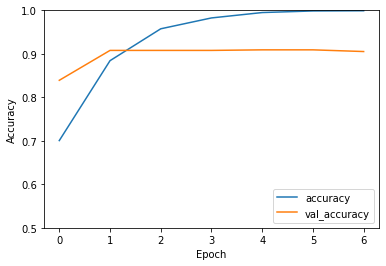

In [ ]:
import matplotlib.pyplot as plt
plt.plot(cnn_lstm_model_history.history['accuracy'], label='accuracy')
plt.plot(cnn_lstm_model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
val_sequences = tokenizer.texts_to_sequences(test.text)
val_data = keras.preprocessing.sequence.pad_sequences(val_sequences, value=0.0,
                                                      padding='post', maxlen= padding_length)
val_labels = test.tag

In [ ]:
test_loss, test_acc = cnn_lstm_model.evaluate(val_data,val_labels.astype(int))

41/41 [==============================] - 0s 12ms/step - loss: 0.4217 - accuracy: 0.9065


In [ ]:
predicted_probability = cnn_lstm_model.predict(val_data)
print(predicted_probability)

predicted_classess = np.argmax(cnn_lstm_model.predict(val_data), axis=-1)
print(predicted_classess)

[[3.8821898e-07 9.9999964e-01]
 [5.1687033e-07 9.9999952e-01]
 [9.9983001e-01 1.6999961e-04]
 ...
 [1.3847534e-04 9.9986148e-01]
 [9.9125602e-05 9.9990082e-01]
 [2.4113901e-05 9.9997592e-01]]
[1 1 0 ... 1 1 1]


In [ ]:
qa=pd.read_csv('news.csv')

In [ ]:
qa.head(2)

In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
sentences=["WHO has stated there is no possibility that coronavirus is transmitted by aerosols."]

In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
corpus = list(qa['question'].values)
corpus=sentences+corpus
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

In [ ]:
! pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')


sentence_embeddings = model.encode(corpus)

for sentence, embedding in zip(sentences, sentence_embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

In [ ]:
from sentence_transformers import SentenceTransformer, util
sim_list=[]
for i in range(len(sentence_embeddings)):
  sim=util.pytorch_cos_sim(sentence_embeddings[0], sentence_embeddings[i]).item()
  sim_list.append(sim)

In [ ]:
max(sim_list[1:])

In [ ]:
sim_list.index(max(sim_list[1:]))

In [ ]:
corpus[231]

In [ ]:
tmp

In [ ]:
puncts = list(string.punctuation)
def clean_data(text):
  # delete punctuation
  for punc in puncts:
    if punc in text:
      text = text.replace(punc, f'')
  #make the text lower case
  text=text.lower()
  # delete the url
  text=re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text)
  # delete the email
  text=re.sub(r'^([\w]+\.*)([\w]+)\@[\w]+\.\w{3}(\.\w{2}|)', '', text)
  # delete @someone
  text=re.sub(r'@\S+', '', text)
  # delete #tags
  text=re.sub(r'#\S+', '', text)
  # delete \n
  text=re.sub(r'^\s*$(?:\n|\r\n)', '', text)
  return text

In [ ]:
qa['question']=qa['question'].apply(clean_data)

In [ ]:
! pip install spacy
! pip install spacy_cld
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.language import Language
from spacy_cld import LanguageDetector
nlp = spacy.load('en')
language_detector = LanguageDetector()
nlp.add_pipe(language_detector)
stopwords=list(STOP_WORDS)

for word in stopwords:
    nlp.vocab[word].is_stop = True
qa['question'] = qa['question'].apply(lambda text: 
                                          " ".join(token.lemma_ for token in nlp(text) 
                                                   if not token.is_stop))

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
wnl = WordNetLemmatizer() 
for i in range(len(qa)):
  qa['question'][i]=wnl.lemmatize(qa['question'][i])

In [ ]:
df = pd.DataFrame( {'Sumcription': ["WHO has stated there is no possibility that coronavirus is transmitted by aerosols."]})

df['Sumcription_lema'] = df.Sumcription.apply(lambda text: 
                                          " ".join(token.lemma_ for token in nlp(text) 
                                                   if not token.is_stop))
for i in range(len(df)):
  df['Sumcription_lema'][i]=wnl.lemmatize(df['Sumcription_lema'][i])

In [ ]:
corpus = list(qa['question'].values)
sentences=list(df['Sumcription_lema'].values)
corpus=sentences+corpus

In [ ]:
def jaccard_similarity(x,y):
  """ returns the jaccard similarity between two lists """
  intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
  union_cardinality = len(set.union(*[set(x), set(y)]))
  return intersection_cardinality/float(union_cardinality)


In [ ]:
sentences = [sent.lower().split(" ") for sent in corpus]
sim_jac=[]
for i in range(len(corpus)):
  sim=jaccard_similarity(sentences[0], sentences[i])
  sim_jac.append(sim)

In [ ]:
import numpy as np
max2 = np.sort(sim_jac)[-2]
max_index2 = np.argsort(sim_jac)[-2]

In [ ]:
max2

In [ ]:
max_index2

In [ ]:
news=pd.read_csv('news.csv')

In [ ]:
news['question'][148]

In [ ]:
from math import sqrt, pow, exp
 
def squared_sum(x):
  """ return 3 rounded square rooted value """
 
  return round(sqrt(sum([a*a for a in x])),3)
 
def euclidean_distance(x,y):
  """ return euclidean distance between two lists """
 
  return 1-exp(sqrt(sum(pow(a-b,2) for a, b in zip(x, y))))

In [ ]:
embeddings = [nlp(sentence).vector for sentence in sentences]

dis_sum=[]
for i in range(len(corpus)):
  distance = euclidean_distance(embeddings[0], embeddings[i])
  dis_sum.append(distance)


In [ ]:
sentences